# **Gold Price Prediction Using CNN-LSTM**




## Import and Install Library

In [ ]:
!pip install -q keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from google.colab import drive

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten

import random as python_random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import datetime

## Load Dataset

In [ ]:
#Mount to google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !ls "/content/drive/MyDrive/TugasAkhir/Code/" 

In [ ]:
data = pd.read_excel("/content/drive/MyDrive/TugasAkhir/Code/Dataset/2-weekly.xlsx")

In [ ]:
data.head()

,Date,Prices
0,1978-12-29,226.00
1,1979-01-05,225.50
2,1979-01-12,217.60
3,1979-01-19,230.55
4,1979-01-26,235.45


In [ ]:
data.tail()

,Date,Prices
2200,2021-02-26,1742.85
2201,2021-03-05,1696.25
2202,2021-03-12,1704.80
2203,2021-03-19,1735.20
2204,2021-03-26,1731.80


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2205 non-null   datetime64[ns]
 1   Prices  2205 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.6 KB


## Pre-Processing

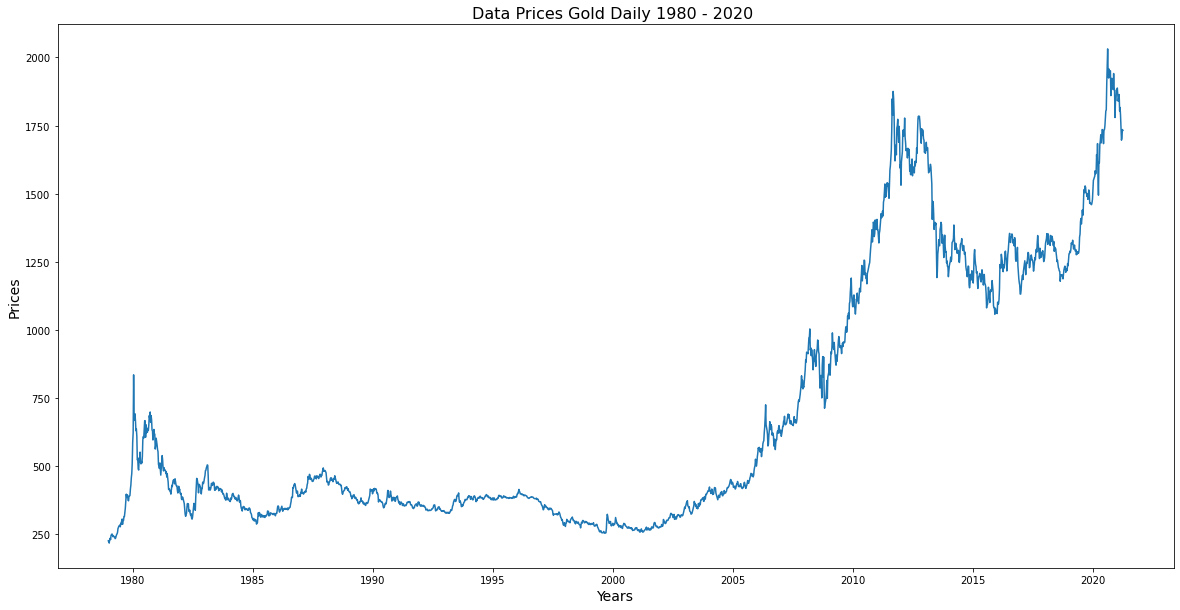

In [ ]:
#Check the pattern of dataset

plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['Prices'])
plt.title("Data Prices Gold Daily 1980 - 2020 ", fontsize=16)
plt.ylabel("Prices", fontsize=14)
plt.xlabel("Years", fontsize=14)
plt.show()

In [ ]:
#Filter Data
data = data[(data['Date'] >= pd.Timestamp(2005,3,26)) & (data['Date'] <= pd.Timestamp(2021,3,26))]  

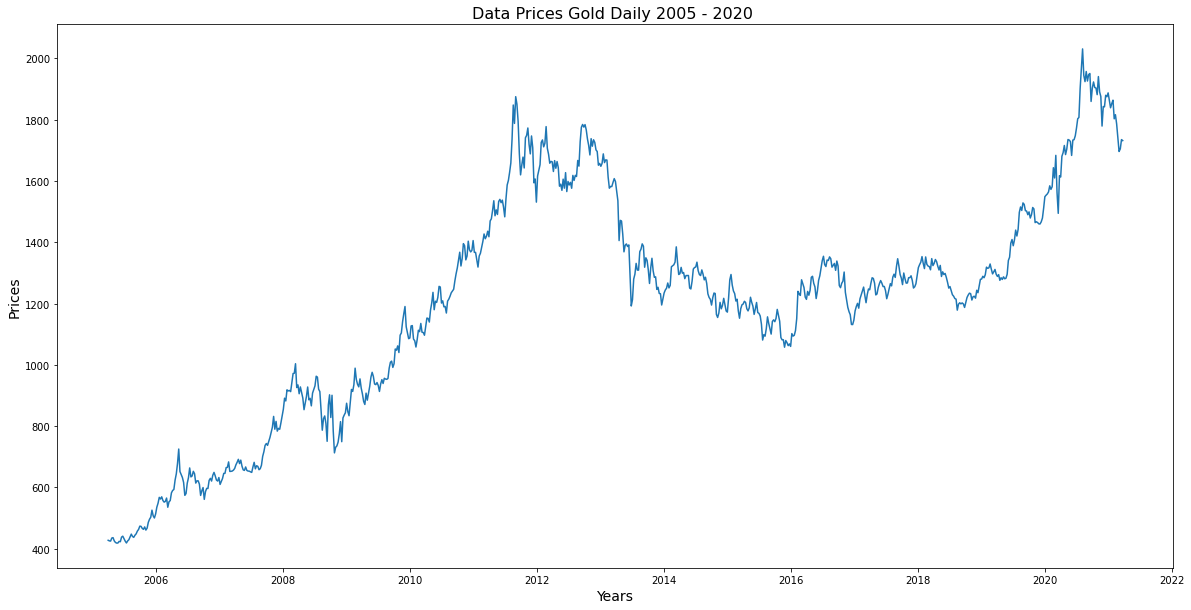

In [ ]:
#Check the pattern of dataset after filter

plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['Prices'])
plt.title("Data Prices Gold Daily 2005 - 2020 ", fontsize=16)
plt.ylabel("Prices", fontsize=14)
plt.xlabel("Years", fontsize=14)
plt.show()

In [ ]:
#Check the types of all atributes
data.dtypes

Date      datetime64[ns]
Prices           float64
dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 1370 to 2204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    835 non-null    datetime64[ns]
 1   Prices  835 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


In [ ]:
data.head()

,Date,Prices
1370,2005-04-01,427.15
1371,2005-04-08,425.20
1372,2005-04-15,424.60
1373,2005-04-22,434.60
1374,2005-04-29,435.70


### Check Ratio

In [ ]:
#Split into Data Train and Data Test (80:20)
train_size = int(len(data) * 0.80)
test_size = (int(len(data) - train_size))

#Data training
data_train = data[0:train_size]

#Data testing
data_test = data[train_size:len(data)]

print("The amount of data train: ", len(data_train))
print("The amount of data train: ", len(data_test))

The amount of data train:  668
The amount of data train:  167


In [ ]:
#Check missing values in data train
data_train.isnull().sum()

Date      0
Prices    0
dtype: int64

In [ ]:
#Check missing values in data test
data_test.isnull().sum()

Date      0
Prices    0
dtype: int64

In [ ]:
#Make data train into numpy array
arr_price_train = data_train['Prices'].to_numpy()
# arr_date_train = data_train['Date'].to_numpy()

#Make data test into numpy array
arr_price_test = data_test['Prices'].to_numpy()
# arr_date_test = data_test['Date'].to_numpy()

In [ ]:
scalerMinMax = MinMaxScaler()
# scalerStandard = StandardScaler() 

#Normalize the data train
scaled_data_train = scalerMinMax.fit_transform(arr_price_train.reshape(-1,1))

#Normalize the data test
scaled_data_test = scalerMinMax.fit_transform(arr_price_test.reshape(-1,1))

The first step is to split the input sequences into subsequences that can be processed by the CNN model. For example, we can first split our univariate time series data into input/output samples with four steps as input and one as output. Each sample can then be split into two sub-samples, each with two time steps. The CNN can interpret each subsequence of two time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. The input data can then be reshaped to have the required structure

In [ ]:
#Split a univariate sequence into samples
def splitSequences(data, n_steps):
    x, y = list(),list()
    for i in range(len(data)):
        #Find the end of this pattern
        end = i + n_steps
        #Check if we are beyond the sequence
        if end > len(data)-1:
            break
        #Gather input and outputs part of the pattern
        seq_x, seq_y = data[i:end], data[end]
        x.append(seq_x)
        y.append(seq_y)
    return x, y

In [ ]:
#Scaled data train became the input sequence
input_seq_train = scaled_data_train

#Scaled data test became the input sequence
input_seq_test = scaled_data_test

In [ ]:
#Choose a number of time steps (In this case time steps = 1)

n_steps = 4
train_X, train_y = splitSequences(input_seq_train, n_steps)
test_X, test_y = splitSequences(input_seq_test, n_steps)

print("The amount of data train: ", len(train_X))
print("The amount of data train: ", len(test_X))

The amount of data train:  664
The amount of data train:  163


In [ ]:
data_train['Prices'].head()

1370    427.15
1371    425.20
1372    424.60
1373    434.60
1374    435.70
Name: Prices, dtype: float64

In [ ]:
#Make data into numpy array

train_X = np.asarray(train_X)
train_y = np.asarray(train_y)

test_X = np.asarray(test_X)
test_y = np.asarray(test_y)

In [ ]:
#Reshape from [samples, timesteps] into[samples, subsequence, timesteps, features]
n_features = 1
n_steps = 4
n_seq = 1

# #Reshape for data train
train_X = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))

#Reshape for data test
test_X = test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))

In [ ]:
train_X.shape

(664, 1, 4, 1)

## Building Model

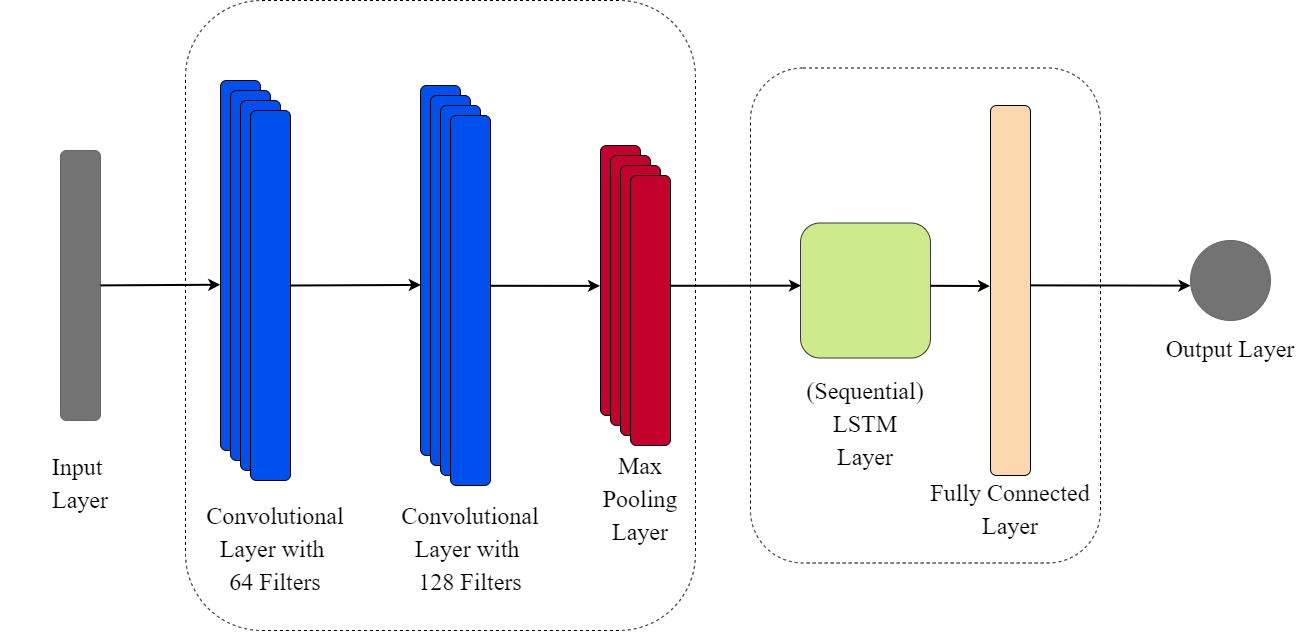

In [ ]:
#Not get random result

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

In [ ]:
# Define Model CNN-LSTM

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation="relu"), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
# model.add(Dropout(0.1))
model.add(Dense(32)) # Code for Fully Connected Layer
model.add(Dense(1, activation="relu")) # Output Layer
model.compile(optimizer='Adam', loss='mean_squared_error')

earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

ValueError: ignored

In [ ]:
model.summary()

## Training Model

In [ ]:
#Training Model
model_train = model.fit(train_X, train_y, validation_split=0.33, epochs=1000, batch_size=256, verbose=1, callbacks=[earlyStop])

In [ ]:
#Loss Visualization for data training and validation

plt.figure(figsize=(15,10))
plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [ ]:
result = model.predict(train_X)

In [ ]:
train_y.shape

In [ ]:
result.shape

In [ ]:
#Invert Scalled Value into Actual Value

result = scalerMinMax.inverse_transform(result.reshape(-1,1))
train_y = scalerMinMax.inverse_transform(train_y.reshape(-1,1))

In [ ]:
#Flatten the Data

result = result.flatten()
train_y = train_y.flatten()

In [ ]:
#Check the RMSE and MAE (Training Process)

rmse_train = np.sqrt(mean_squared_error(train_y, result))
print('Train Root Mean Squared Error:', rmse_train)

mae_train = (mean_absolute_error(train_y, result))
print('Train Mean Absolute Error:', mae_train)

In [ ]:
#Make the length date -4
data_train = data_train[4:]
data_test = data_test[4:]

In [ ]:
#Visuzalize the Predicted Result and Actual Data Train

plt.figure(figsize=(20,10))
plt.title("Training Predicted Price")
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(data_train['Date'],result)
plt.plot(data_train['Date'],train_y)
plt.legend(['True','Predict'], loc='upper right')
plt.show()

## Testing

In [ ]:
#Testing
predicted_result = model.predict(test_X, verbose=0)

In [ ]:
#Invert Scalled Value into Actual Value

predicted_result = scalerMinMax.inverse_transform(predicted_result.reshape(-1,1))
test_y = scalerMinMax.inverse_transform(test_y.reshape(-1,1))

In [ ]:
#Flatten the Data

predicted_result = predicted_result.flatten()
test_y = test_y.flatten()

In [ ]:
#Check the RMSE and MAE (Testing Process)

rmse = np.sqrt(mean_squared_error(test_y, predicted_result))
print('Test Root Mean Squared Error:', rmse)

mae = (mean_absolute_error(test_y, predicted_result))
print('Test Mean Absolute Error:', mae)

In [ ]:
#Visuzalize the Predicted Result and Actual Data Test

plt.figure(figsize=(20,10))
plt.title("Predicted Price")
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.plot(data_test['Date'], predicted_result)
plt.plot(data_test['Date'], test_y)
plt.legend(['Actual','Prediction Result'], loc='upper right')
plt.show()